In [ ]:
!pip install pydicom

In [ ]:
import tensorflow as tf


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pydicom
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib import cm
import os
import seaborn as sns
from skimage import measure
import keras

import cv2
from keras.utils import to_categorical
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataDir = '/content/drive/MyDrive/Colab Notebooks/RSNA Pneumonia/unzipped Data/stage_2_train_images/'

In [ ]:
print('Storing the DICOM files as a dictionary under trainDicomFiles such that the keys are the patient\
ids and the values are the path of the files corresponding to the image.')
trainDicomFiles = {}



for root, dirs, files in os.walk(dataDir):
    for fileName in files:
            trainDicomFiles[fileName.split(sep='.')[0]] = os.path.join(dataDir, fileName)     
        
print('\nGenerating the data frame for the training data labels.')
trainLabelDf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RSNA Pneumonia/unzipped Data/stage_2_train_labels.csv')
trainLabelDetailedDf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RSNA Pneumonia/unzipped Data/stage_2_detailed_class_info.csv')

# Joining the class information from the detailed class info CSV to the train labels CSV.
trainLabelDf['class'] = trainLabelDetailedDf['class']

# As the training labels file contain multiple rows for each patient corresponding to the number of bounding boxes present
# in case of a person with lung opacity, we can group the labels by patient id to find number of unique patients in 
# the label file.

print('\nAs the training label data frame may contain multiple records for a patient to represent the bounding box, we can \
store the bounding box labels in a property called boundingBox that contains a array of box data stored as \
{x, y, width, height}')

uniquePatientIds = np.unique(trainLabelDf.patientId)
trainLabelAndBoundingBoxDf = pd.DataFrame(columns=['patientId', 'target', 'class', 'boundingBox', 'num_of_opacities']
                                          , index=uniquePatientIds)

patientIdBasedGroups = trainLabelDf.groupby('patientId')
#counter = 0
for patientId, group in patientIdBasedGroups:
#     if counter > 20:
#         break
    trainLabelAndBoundingBoxDf.loc[patientId]['patientId'] = patientId
    trainLabelAndBoundingBoxDf.loc[patientId]['num_of_opacities'] = 0
    boundingBox = []
    for index, groupItem in group.iterrows():
        
        trainLabelAndBoundingBoxDf.loc[patientId]['target'] = groupItem['Target']
        trainLabelAndBoundingBoxDf.loc[patientId]['class'] = groupItem['class']
        
        if(not np.isnan(groupItem['x'])):
            boundingBox.append((groupItem['x'], groupItem['y'], groupItem['width'], groupItem['height']))
            trainLabelAndBoundingBoxDf.loc[patientId]['num_of_opacities'] += 1
            
    trainLabelAndBoundingBoxDf.loc[patientId]['boundingBox'] = boundingBox
#     counter += 1

display(trainLabelAndBoundingBoxDf.head())

print('\nShape of training labels with bounding box list: ', trainLabelAndBoundingBoxDf.shape)


Storing the DICOM files as a dictionary under trainDicomFiles such that the keys are the patientids and the values are the path of the files corresponding to the image.

Generating the data frame for the training data labels.

As the training label data frame may contain multiple records for a patient to represent the bounding box, we can store the bounding box labels in a property called boundingBox that contains a array of box data stored as {x, y, width, height}


,patientId,target,class,boundingBox,num_of_opacities
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,[],0
000924cf-0f8d-42bd-9158-1af53881a557,000924cf-0f8d-42bd-9158-1af53881a557,0,Normal,[],0
000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985,1,Lung Opacity,"[(316.0, 318.0, 170.0, 478.0), (660.0, 375.0, ...",2
000fe35a-2649-43d4-b027-e67796d412e0,000fe35a-2649-43d4-b027-e67796d412e0,1,Lung Opacity,"[(570.0, 282.0, 269.0, 409.0), (83.0, 227.0, 2...",2
001031d9-f904-4a23-b3e5-2c088acd19c6,001031d9-f904-4a23-b3e5-2c088acd19c6,1,Lung Opacity,"[(66.0, 160.0, 373.0, 608.0), (552.0, 164.0, 3...",2



Shape of training labels with bounding box list:  (26684, 5)


In [ ]:
print('As the data available for training is large, we can build a data generator class that can help in building the input data \
in batches to avoid overwhelming the system memory.')
print('We can extend the keras sequence class to get the data generator.')

class LungDataGenerator(keras.utils.Sequence):
    def __init__(self, patientIds, batch_size=32, dim=(1024,1024), shuffle=True):
        self.patientIds = patientIds
        self.batch_size = batch_size
        self.dim=dim
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __load__(self, patientIds):
        # Load the dicom file as a numpy array
        dicom_image = pydicom.dcmread(trainDicomFiles[patientIds]).pixel_array

        targetLabelDf = trainLabelAndBoundingBoxDf.loc[patientIds]
        
        dicom_image = cv2.resize(dicom_image, (self.dim[0], self.dim[1]))
        dicom_image = np.expand_dims(dicom_image, -1)
        target = targetLabelDf['target']
        return dicom_image, target

    def __len__(self):
        # Represents the number of batches per epoch
        return int(len(self.patientIds) / self.batch_size)
    
    def __getitem__(self, index):
        # Generates the indexes associated with one batch
        targetPatientIds = self.patientIds[index * self.batch_size : (index + 1) * self.batch_size]
        
        items = [self.__load__(id) for id in targetPatientIds]
        
        imgs, targets  = zip(*items)

        # Create numpy batch
        imgs = np.array(imgs)
        targets = np.array(targets)
        return imgs, targets
        
    def on_epoch_end(self):
        # Shuffles the data after every epoch
        if self.shuffle:
            np.random.shuffle(self.patientIds)

As the data available for training is large, we can build a data generator class that can help in building the input data in batches to avoid overwhelming the system memory.
We can extend the keras sequence class to get the data generator.


In [ ]:
print('Now we can define the metrics for loss reduction as below:')

print('loss')
def bce_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred)



Now we can define the metrics for loss reduction as below:
loss


In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Activation, Dense

def LeNet(input_shape=(64,64,1), k_size=3):

    data = keras.Input(shape=input_shape)
    conv1 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(data)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(filters=512, kernel_size=k_size, padding='same', activation='relu')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(filters=1024, kernel_size=k_size, padding='same', activation='relu')(pool4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Convolution2D(filters=2048, kernel_size=k_size, padding='same', activation='relu')(pool5)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)

    flatten = Flatten()(pool6)
    
    dense1 = Dense(2048, activation='relu')(flatten)
    
    dense2 = Dense(1024, activation='relu')(dense1)
    
    dense3 = Dense(512, activation='relu')(dense2)
    
    dense4 = Dense(256, activation='relu')(dense3)

    dense5 = Dense(128, activation='relu')(dense4)
    
    dense6 = Dense(64, activation='relu')(dense5)
   
    dense7 = Dense(1, activation = 'sigmoid')(dense6)#activation='softmax'

    output = dense7
    model = Model(data, output)
    return model



print('Generating Improved LeNet-5 network instance.')
lenet_model = LeNet()
lenet_model.compile(optimizer='adam', loss=bce_loss, metrics=['accuracy'])

epoch_count = 5

# Define cosine annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = epoch_count
    return lr * (np.cos(np.pi * x / epochs) + 1.) / 2

lenet_model.summary()


Generating Improved LeNet-5 network instance.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d

In [ ]:
print('Training the model.')
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

training_data_percent = 0.7
training_data_end_index = int(trainLabelAndBoundingBoxDf.shape[0] * training_data_percent)
training_patientIds_box = trainLabelAndBoundingBoxDf['patientId'][0:training_data_end_index]
validation_patientIds_box = trainLabelAndBoundingBoxDf['patientId'][training_data_end_index:]

params = {'dim': (64, 64), 'batch_size': 32, 'shuffle': True}
training_data_generator_box = LungDataGenerator(training_patientIds_box, **params)

validation_data_generator_box = LungDataGenerator(validation_patientIds_box, **params)

history = lenet_model.fit(training_data_generator_box, validation_data=validation_data_generator_box, callbacks=[learning_rate], epochs=epoch_count, workers=4, use_multiprocessing=False)

Training the model.
Epoch 1/5
583/583 [==============================] - 189s 322ms/step - loss: 1.2660 - accuracy: 0.7594 - val_loss: 0.4286 - val_accuracy: 0.8384
Epoch 2/5
583/583 [==============================] - 187s 320ms/step - loss: 0.4565 - accuracy: 0.7855 - val_loss: 0.3804 - val_accuracy: 0.8332
Epoch 3/5
583/583 [==============================] - 187s 319ms/step - loss: 0.4465 - accuracy: 0.7936 - val_loss: 0.3731 - val_accuracy: 0.8351
Epoch 4/5
583/583 [==============================] - 187s 320ms/step - loss: 0.4288 - accuracy: 0.8007 - val_loss: 0.4409 - val_accuracy: 0.7977
Epoch 5/5
583/583 [==============================] - 187s 320ms/step - loss: 0.4087 - accuracy: 0.8128 - val_loss: 0.3759 - val_accuracy: 0.8340


Below is the representation of variation of loss


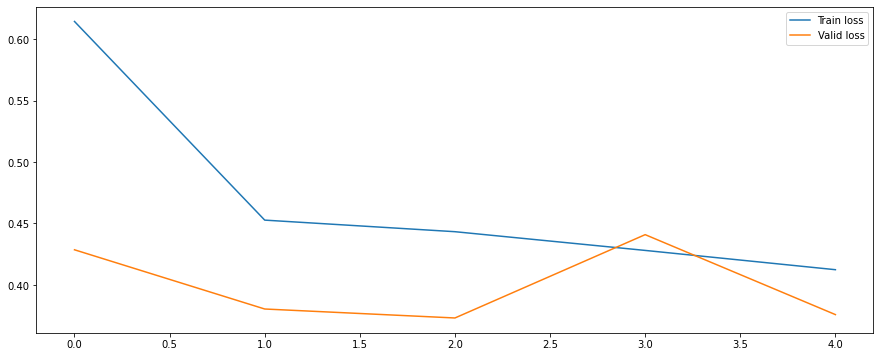

In [ ]:
print('Below is the representation of variation of loss')
plt.figure(figsize=(15,6))

plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()

plt.show()

We can generate the y_pred and y_true arrays to hold the target values (predicted and actual) for all the validation data points.
Based on the actual and predicted target values, we can display the confusion matrix as below.


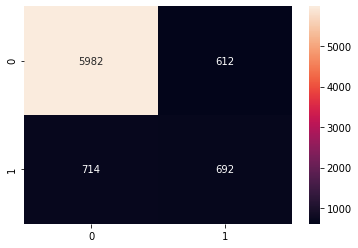


Below is the classification report based on the actual and predicted target values.
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6594
           1       0.53      0.49      0.51      1406

    accuracy                           0.83      8000
   macro avg       0.71      0.70      0.71      8000
weighted avg       0.83      0.83      0.83      8000



In [ ]:
print('We can generate the y_pred and y_true arrays to hold the target values (predicted and actual) for all the validation \
data points.')
from functools import reduce
y_pred = []
y_true = []

for imgs, targets in validation_data_generator_box:
    predictions = lenet_model.predict(imgs)
    
    # Loop through the predictions along with the actual targets
    
    
    comp = predictions[:] > 0.5

    comp = [int(elem) for elem in comp]
        
    y_pred.append(comp)
    y_true.append(targets)

y_pred = reduce(lambda x,y: x+y,y_pred)  
y_true = [item for sublist in y_true for item in sublist]
print('Based on the actual and predicted target values, we can display the confusion matrix as below.')
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

print('\nBelow is the classification report based on the actual and predicted target values.')
print(classification_report(y_true, y_pred, labels=[0,1]))

Reference : "A Pneumonia Detection Method Based on Improved
Convolutional Neural Network"by Xin Li , Fan Chen , Haijiang Hao , Mengting Li 